<a href="https://colab.research.google.com/github/julkim22/Data-Analysis/blob/main/MetaAnalysis_autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install PythonMeta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 2.8 MB/s eta 0:00:00


In [ ]:
import PythonMeta as PMA
import plotly.graph_objects as go

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats, optimize

from statsmodels.regression.linear_model import WLS
from statsmodels.genmod.generalized_linear_model import GLM

from statsmodels.stats.meta_analysis import (
    effectsize_smd,
    effectsize_2proportions,
    combine_effects,
    _fit_tau_iterative,
    _fit_tau_mm,
    _fit_tau_iter_mm,
)

In [ ]:
def showstudies(studies,dtype):
    #show continuous data
    if dtype.upper()=="CONT":
        text = "%-10s %-30s %-30s \n"%("Study ID","Experiment Group","Control Group")
        text += "%-10s %-10s %-10s %-10s %-10s %-10s %-10s \n"%(" ","m1","sd1","n1","m2","sd2","n2")
        for i in range(len(studies)):
            text += "%-10s %-10s %-10s %-10s %-10s  %-10s %-10s \n"%(
            studies[i][6],        #study ID
            str(studies[i][0]),   #mean of group1
            str(studies[i][1]),   #SD of group1
            str(studies[i][2]),   #total num of group1
            str(studies[i][3]),   #mean of group2
            str(studies[i][4]),   #SD of group2
            str(studies[i][5])    #total num of group2
            )
        return text

    #show dichotomous data
    text = "%-10s %-20s %-20s \n"%("Study ID","Experiment Group","Control Group")
    text += "%-10s %-10s %-10s %-10s %-10s \n"%(" ","e1","n1","e2","n2")
    for i in range(len(studies)):
        text += "%-10s %-10s %-10s %-10s %-10s \n"%(
        studies[i][4],        #study ID
        str(studies[i][0]),   #event num of group1
        str(studies[i][1]),   #total num of group1
        str(studies[i][2]),   #event num of group2
        str(studies[i][3])    #total num of group2
        )
    return text

Study ID   Experiment Group     Control Group        
           e1         n1         e2         n2         
Green2022  118        122        119        127        
Kent2021   34         35         34         36         
Nguyen2021 14         15         12         13         
Afsharnejad2022 35         46         32         44         

Random MH RR
Study ID   n       ES[95% CI]         Weight(%)
Green2022  249     1.03[0.98 1.09]    68.92
Kent2021   71      1.03[0.93 1.13]    22.48
Nguyen2021 28      1.01[0.82 1.24]     4.98
Afsharnejad2022 90      1.05[0.82 1.33]     3.62
RR         438     1.03[0.98 1.08]      100
4 studies included (N=438)
Heterogeneity: Tau²=0.000 Q(Chisquare)=0.06(p=0.990); I²=0%
Overall effect test: z=1.29, p=0.198



/usr/local/lib/python3.10/dist-packages/PythonMeta/core.py:3546: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([round(_x_tran1(x),2) for x in ax.get_xticks()])
/usr/local/lib/python3.10/dist-packages/PythonMeta/core.py:3666: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([round(_x_tran1(x),2) for x in ax.get_xticks()])


(-0.05808287733151696, -0.38262940301342424, array(0.73883049), 0.1517993046903381, array([-0.71122257,  0.59505682]))
Study ID   Experiment Group               Control Group                  
           m1         sd1        n1         m2         sd2        n2         
Green2022  6.2        4.1        38.0       5.3         4.1        42.0       
Kent2021   79.61      13.51      36.0       75.31       13.95      35.0       
Nguyen2021 72.0       13.9       14.0       65.4        14.9       12.0       
Afsharnejad2022 42.6       17.5       46.0       22.6        0.0        44.0       

Random IV MD
Study ID   n       ES[95% CI]         Weight(%)
Green2022  80      0.90[-0.90 2.70]    27.71
Kent2021   71      4.30[-2.09 10.69]    25.18
Nguyen2021 26      6.60[-4.54 17.74]    20.96
Afsharnejad2022 90      20.00[14.94 25.06]    26.15
MD         267     7.95[-2.25 18.14]      100
4 studies included (N=267)
Heterogeneity: Tau²=96.835 Q(Chisquare)=49.14(p=0.000); I²=93.9%
Overall effect test

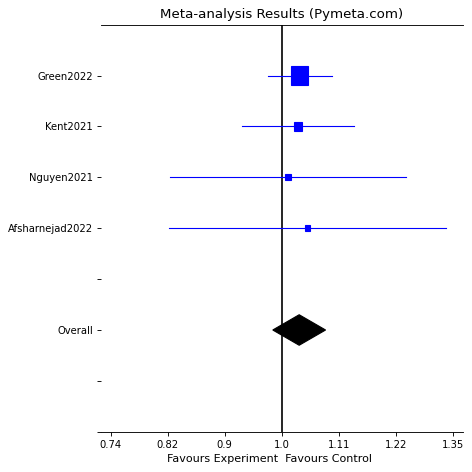

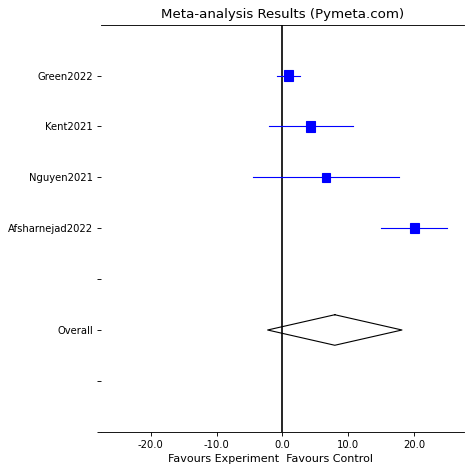

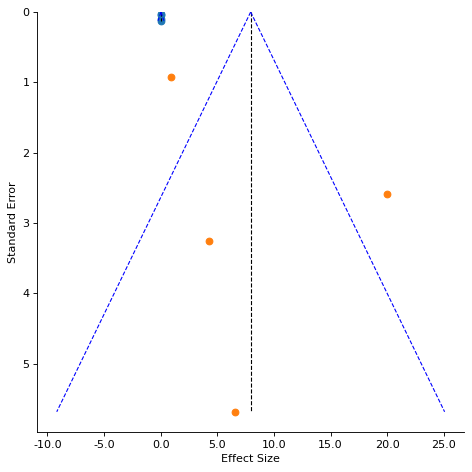

In [ ]:
def showresults(rults):
    text = "%-10s %-6s  %-18s %-10s"%("Study ID","n","ES[95% CI]","Weight(%)\n")
    for i in range(1,len(rults)):
        text += "%-10s %-6d  %-4.2f[%.2f %.2f]   %6.2f\n"%(   # for each study
        rults[i][0],     #study ID
        rults[i][5],     #total num
        rults[i][1],     #effect size
        rults[i][3],     #lower of CI
        rults[i][4],     #higher of CI
        100*(rults[i][2]/rults[0][2])  #weight
        )
    text += "%-10s %-6d  %-4.2f[%.2f %.2f]   %6d\n"%(         # for total effect
        rults[0][0],     #total effect size name
        rults[0][5],     #total N (all studies)
        rults[0][1],     #total effect size
        rults[0][3],     #total lower CI
        rults[0][4],     #total higher CI
        100
        )
    text += "%d studies included (N=%d)\n"%(len(rults)-1,rults[0][5])
    text += "Heterogeneity: Tau\u00b2=%.3f "%(rults[0][12]) if not rults[0][12]==None else "Heterogeneity: "
    text += "Q(Chisquare)=%.2f(p=%s); I\u00b2=%s\n"%(
        rults[0][7],     #Q test value
        rults[0][8],     #p value for Q test
        str(round(rults[0][9],2))+"%")   #I-square value
    text += "Overall effect test: z=%.2f, p=%s\n"%(rults[0][10],rults[0][11])  #z-test value and p-value

    return text

def main(stys,settings):
    d = PMA.Data()  #Load Data class
    m = PMA.Meta()  #Load Meta class
    f = PMA.Fig()   #Load Fig class

    #You should always tell the datatype first!!!
    d.datatype = settings["datatype"]                #set data type, 'CATE' for binary data or 'CONT' for continuous data
    studies = d.getdata(stys)                        #load data
    #studies = d.getdata(d.readfile("studies.txt"))  #get data from a data file, see examples of data files
    print(showstudies(studies,d.datatype))           #show studies

    m.subgroup=d.subgroup                            #set the subgroup
    m.datatype=d.datatype                            #set data type for meta-analysis calculating
    m.models = settings["models"]                    #set effect models: 'Fixed' or 'Random'
    m.algorithm = settings["algorithm"]              #set algorithm, based on datatype and effect size
    m.effect = settings["effect"]                    #set effect size:RR/OR/RD for binary data; SMD/MD for continuous data
    results = m.meta(studies)                        #performing the analysis
    print(m.models + " " + m.algorithm + " " + m.effect)
    print (showresults(results))                     #show results table
    f.forest(results).show()                         #show forest plot
    f.funnel(results).show()                         #show funnel plot
    print(m.Eggers_test(results))                    #Eggers_test: (Intercept, t-value, p-value, SD  and CI)

if __name__ == '__main__':
    samp_cate = [
    "Green 2022,118,122,119,127",
    "Kent 2021,34,35,34,36",
    "Nguyen 2021,14,15,12,13",
    "Afsharnejad 2022,35,46,32,44"]

    samp_cont=[  #this array can be stored into a data file by lines, and loaded with d.readfile("filename")
    "Green 2022, 6.2,  4.1,  38,  5.3,  4.1,  42",
    "Kent 2021,    79.61,  13.51,  36,  75.31,  13.95,  35",
    "Nguyen 2021,    72, 13.9, 14,  65.4, 14.9, 12",
    "Afsharnejad 2022,   42.6, 17.5, 46,  22.6, 0, 44",
    " ",
    "#This is a sample of continuous data.",
    "#Input one study in a line;",
    "#Syntax: study name, m1, sd1, n1, m2, sd2, n2",
    "#m1, sd1, n1: mean, SD and number of experiment group;",
    "#m2, sd2, n2: mean, SD and number of control group."]

    #sample 1: dichotomous data
    settings={
    "datatype":"CATE",  #for CATEgorical/count/binary/dichotomous data
    "models":"Random",             #models: Fixed or Random
    "algorithm":"MH",             #algorithm: MH, Peto or IV
    "effect":"RR"}                #effect size: RR, OR, RD
    main(samp_cate,settings)

    #sample 2: continuous data
    settings={
    "datatype":"CONT",  #for CONTinuous data
    "models":"Random",             #models: Fixed or Random
    "algorithm":"IV",             #algorithm: IV
    "effect":"MD"}                #effect size: MD, SMD
    main(samp_cont,settings)

In [ ]:
import pandas as pd
from scipy import stats

# Create a dataframe with the study data
df = pd.DataFrame({
    'Study': ['Green et.al.', 'Kent et.al.', 'Nguyen et.al.'],
    'Control': [42, 63.76, 65.4],
    'Treatment': [38, 58.21, 72],
})

# Conduct independent t-tests for each study
for i, row in df.iterrows():
    control = row['Control']
    treatment = row['Treatment']
    t, p = stats.ttest_ind(control, treatment)
    print(f"Study: {row['Study']}, t = {t:.2f}, p = {p:.3f}")

Study: Green et.al., t = nan, p = nan
Study: Kent et.al., t = nan, p = nan
Study: Nguyen et.al., t = nan, p = nan


<ipython-input-9-8e607d1eae5d>:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p = stats.ttest_ind(control, treatment)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [ ]:
import numpy as np

effect_sizes = [0.90, 4.30, 6.60, 20.00, 23.40] # MD values
mean_effect = np.mean(effect_sizes)

print("Mean effect size: ", mean_effect)

Mean effect size:  11.040000000000001


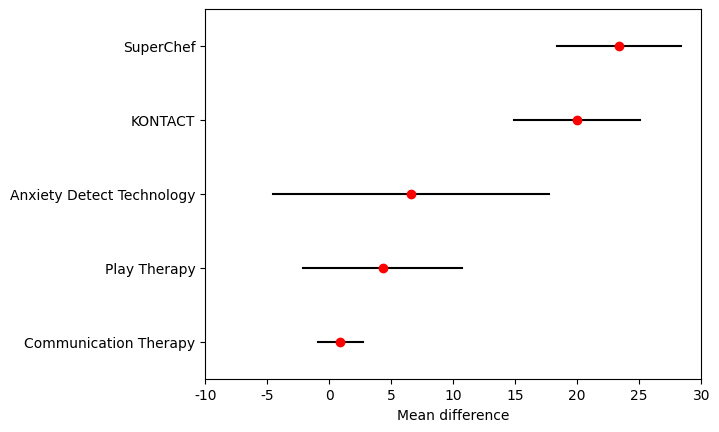

In [ ]:
import matplotlib.pyplot as plt

# Задаем значения для построения леса
effect_sizes = [0.90, 4.30, 6.60, 20.00, 23.40] # MD values
study_names = ["Communication Therapy", "Play Therapy", "Anxiety Detect Technology", "KONTACT", "SuperChef"]
lower_bounds = [-0.90, -2.09, -4.54, 14.94, 18.40] # lower bounds of confidence intervals
upper_bounds = [2.70, 10.69, 17.74, 25.06, 28.40] # upper bounds of confidence intervals

# Создаем фигуру и оси для графика
fig, ax = plt.subplots()

# Устанавливаем оси для графика
ax.set_xlim(-10, 30)
ax.set_ylim(-0.5, 4.5)

# Отображаем данные на графике
for i in range(len(effect_sizes)):
    ax.plot([lower_bounds[i], upper_bounds[i]], [i, i], 'k-')
    ax.plot(effect_sizes[i], i, 'ro')

# Настроим метки для осей
ax.set_yticks(range(len(study_names)))
ax.set_yticklabels(study_names)

ax.set_xlabel('Mean difference')
plt.show()

In [ ]:
import numpy as np

In [ ]:
effect_sizes = [0.90, 4.30, 6.60, 20.00, 23.40] # MD values
mean_effect = np.mean(effect_sizes)

print("Mean effect size: ", mean_effect)

Mean effect size:  11.040000000000001


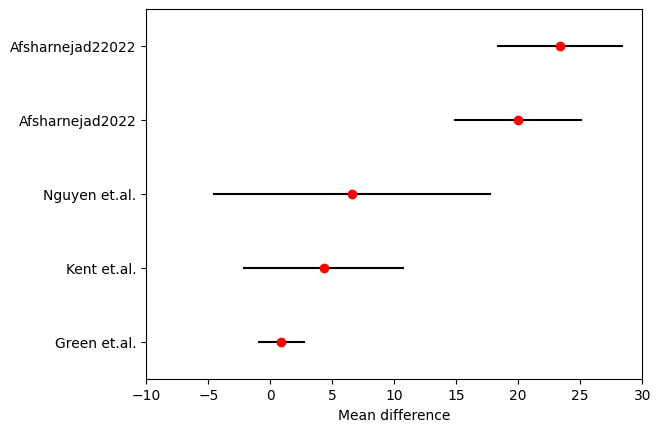

In [ ]:
import matplotlib.pyplot as plt

effect_sizes = [0.90, 4.30, 6.60, 20.00, 23.40] # MD values
study_names = ["Green et.al.", "Kent et.al.", "Nguyen et.al.", "Afsharnejad2022", "Afsharnejad22022"]
lower_bounds = [-0.90, -2.09, -4.54, 14.94, 18.40] # lower bounds of confidence intervals
upper_bounds = [2.70, 10.69, 17.74, 25.06, 28.40] # upper bounds of confidence intervals

fig, ax = plt.subplots()
ax.set_xlim(-10, 30)
ax.set_ylim(-0.5, 4.5)


for i in range(len(effect_sizes)):
    ax.plot([lower_bounds[i], upper_bounds[i]], [i, i], 'k-')
    ax.plot(effect_sizes[i], i, 'ro')


ax.set_yticks(range(len(study_names)))
ax.set_yticklabels(study_names)

ax.set_xlabel('Mean difference')
plt.show()